# LSTM for Bitcoin Prediction

The objective of this project is to develop a deep learning model that predicts positive trends in Bitcoin prices. This project focuses on utilizing LSTM, a type of recurrent neural network, to analyze and forecast time series data, aiming to accurately identify potential upward movements in the cryptocurrency market and provide insights into future price movements. 

LSTM networks are a type of recurrent neural network (RNN) particularly well-suited for time series analysis due to their ability to remember long-term dependencies in data sequences. In the context of this project, the LSTM is used in a "many-to-one" model configuration, where it processes a sequence of data points (historical Bitcoin data) and outputs a single prediction (e.g., an upswing in price). This approach is ideal for time series forecasting, as it allows the model to analyze trends and patterns over time to make informed predictions about future data points.

## Applying Neural Networks to Financial Time Series

In this project, 80 months of daily Bitcoin data sourced from the Yahoo Finance API were used. The approach involves constructing and fine-tuning a stacked LSTM network, tailored to work with a sequence length of 15. This specific sequence length is chosen to capture relevant temporal patterns in the Bitcoin market, allowing for a more informed and accurate prediction of trend movements.

### Import Libraries

In [60]:
# basic imports
import os, random
import pandas as pd
import numpy as np
import datetime as dt
import pandas_ta as ta
from pathlib import Path
from scipy.stats import f_oneway
import yfinance as yf
import pyfolio as pf
import optuna
                                        
# import boruta
from boruta import BorutaPy

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# warnings
import warnings
warnings.filterwarnings('ignore')

# plotting & outputs
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10,6)

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from keras.models import Sequential

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization

#keras
from keras.layers import LSTM, Dropout, Dense
from keras.losses import BinaryCrossentropy


In [61]:
# define seed
def set_seeds(seed=42): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### Tensorboard

TensorBoard is TensorFlow’s visualization toolkit, enabling to track metrics like loss and accuracy, visualize the model graph, view histograms of weights, biases, or other tensors as they change over time.

In [62]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Path to store results

In [63]:
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Retrive Data

In [64]:
# Function to get data
def getdata(df):
    # Ensure datetime is the index and convert it if necessary
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Datetime' in df.columns:
            df.set_index('Datetime', drop=True, inplace=True)
        else:
            print("No Datetime column found.")
            return None
    df['Day'] = df.index.day_name()
    return df

In [65]:
df = yf.download(tickers="BTC-USD", period="80mo")
df = getdata(df)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Day
Date,,,,,,,
2017-05-13,1723.119995,1812.989990,1651.079956,1804.910034,1804.910034,579635008,Saturday
2017-05-14,1800.859985,1831.420044,1776.619995,1808.910034,1808.910034,437196000,Sunday
2017-05-15,1808.439941,1812.800049,1708.540039,1738.430054,1738.430054,731529024,Monday
2017-05-16,1741.699951,1785.939941,1686.540039,1734.449951,1734.449951,959044992,Tuesday
2017-05-17,1726.729980,1864.050049,1661.910034,1839.089966,1839.089966,1064729984,Wednesday
...,...,...,...,...,...,...,...
2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,39821290992,Tuesday
2024-01-10,46121.539062,47647.222656,44483.152344,46627.777344,46627.777344,50114613298,Wednesday
2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,45833734549,Thursday


The DayTransformer is a custom transformer class designed for feature engineering with time series data. It takes a dataframe with datetime information and adds two new features: 'dsin' and 'dcos'. These features are derived from the day of the week, encoded as sine and cosine values to capture the cyclical nature of days in a week. This approach helps preserve the cyclical continuity (e.g., the closeness between Sunday and Monday) which is often important in time series analysis.

In [66]:
# Custom transformer for days
class DayTransformer(BaseEstimator, TransformerMixin):                                  
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
            self.data = pd.DataFrame(
                {
            'WeekDay': ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
                }
            )
            self.daysnum = np.array(self.data.index+1)
            return self
        
    def transform(self, X):  
        Xt = X.copy()
        pi = np.pi
        num = Xt.index.weekday + 1
        Xt['dsin'] = np.sin(2 * pi * num / np.max(self.daysnum))
        Xt['dcos'] = np.cos(2 * pi * num / np.max(self.daysnum))
        Xt = Xt.drop(['Day'], axis=1)
        return Xt

In [67]:
# day transformer
dtrans= DayTransformer()

# fit
dtrans.fit(df)

DayTransformer()

In [68]:
df=dtrans.transform(df)
df

,Open,High,Low,Close,Adj Close,Volume,dsin,dcos
Date,,,,,,,,
2017-05-13,1723.119995,1812.989990,1651.079956,1804.910034,1804.910034,579635008,-7.818315e-01,0.623490
2017-05-14,1800.859985,1831.420044,1776.619995,1808.910034,1808.910034,437196000,-2.449294e-16,1.000000
2017-05-15,1808.439941,1812.800049,1708.540039,1738.430054,1738.430054,731529024,7.818315e-01,0.623490
2017-05-16,1741.699951,1785.939941,1686.540039,1734.449951,1734.449951,959044992,9.749279e-01,-0.222521
2017-05-17,1726.729980,1864.050049,1661.910034,1839.089966,1839.089966,1064729984,4.338837e-01,-0.900969
...,...,...,...,...,...,...,...,...
2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,39821290992,9.749279e-01,-0.222521
2024-01-10,46121.539062,47647.222656,44483.152344,46627.777344,46627.777344,50114613298,4.338837e-01,-0.900969
2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,45833734549,-4.338837e-01,-0.900969


### Class Imbalance

The 'cwts' function is designed to compute class weights. It calculates the weights inversely proportional to the class frequencies. This results in a dictionary with weights for class 0 and class 1, helping to balance the influence of each class during model training.

In [69]:
# Function to compute class weights
def cwts(dfs):
    c0, c1 = np.bincount(dfs['dir'])
    w0 = (1 / c0) * (len(dfs) / 2)
    w1 = (1 / c1) * (len(dfs) / 2)
    return {0: w0, 1: w1}

In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2437.0,2.032372e+04,1.605817e+04,1.723120e+03,7.434182e+03,1.293157e+04,3.024963e+04,6.754973e+04
High,2437.0,2.080061e+04,1.644751e+04,1.785940e+03,7.595160e+03,1.331114e+04,3.063603e+04,6.878962e+04
Low,2437.0,1.980965e+04,1.561583e+04,1.651080e+03,7.280470e+03,1.223326e+04,2.965271e+04,6.638206e+04
Close,2437.0,2.033879e+04,1.605669e+04,1.734450e+03,7.434390e+03,1.296589e+04,3.027113e+04,6.756683e+04
Adj Close,2437.0,2.033879e+04,1.605669e+04,1.734450e+03,7.434390e+03,1.296589e+04,3.027113e+04,6.756683e+04
Volume,2437.0,2.319067e+10,1.891254e+10,4.371960e+08,8.673920e+09,2.012126e+10,3.248331e+10,3.509679e+11
dsin,2437.0,-3.208172e-04,7.072841e-01,-9.749279e-01,-7.818315e-01,-2.449294e-16,7.818315e-01,9.749279e-01
dcos,2437.0,2.558432e-04,7.072196e-01,-9.009689e-01,-9.009689e-01,-2.225209e-01,6.234898e-01,1.000000e+00


In [71]:
# add all factors
df.ta.strategy('All')
df = df.bfill(axis=1)


131it [00:07, 16.45it/s]


In [72]:
# Calculate daily returns
df['Return'] = df['Close'].pct_change().fillna(0)

# Statistical summary
df['Return'].describe()

count    2437.000000
mean        0.002053
std         0.038671
min        -0.371695
25%        -0.014571
50%         0.000988
75%         0.017901
max         0.252472
Name: Return, dtype: float64

In [73]:
# Compute lagged returns
cols = []
for lag in [1, 2, 3, 4, 5]:
    col = f'Return_{lag}'
    df[col] = df.Return.shift(lag)  
    cols.append(col)

# Drop NaN values
df.dropna(inplace=True)

# Binary transformation
cols_bin = []
for col in cols:
    col_bin = f'{col}_bin'
    df[col_bin] = np.digitize(df[col], bins=[0])
    cols_bin.append(col_bin)

# Add other features
df['o2c'] = df['Open'] - df['Close']
df['h2l'] = df['High'] - df['Low']

# Drop unnecessary columns
df.drop(['Return_1', 'Return_2', 'Return_3', 'Return_4', 'Return_5'], axis=1, inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,dsin,dcos,ABER_ZG_5_15,ABER_SG_5_15,...,ZS_30,Return,dir,Return_1_bin,Return_2_bin,Return_3_bin,Return_4_bin,Return_5_bin,o2c,h2l
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-11,2942.409912,2996.600098,2840.530029,2958.110107,2958.110107,1.752400e+09,-2.449294e-16,1.000000,2837.040023,3026.229913,...,1.760476,0.003528,0,1,1,1,0,1,-15.700195,156.070068
2017-06-12,2953.219971,2997.260010,2518.560059,2659.629883,2659.629883,2.569530e+09,7.818315e-01,0.623490,2828.596696,3039.875111,...,0.900573,-0.100902,1,1,1,1,1,0,293.590088,478.699951
2017-06-13,2680.909912,2789.040039,2650.379883,2717.020020,2717.020020,1.781200e+09,9.749279e-01,-0.222521,2819.568018,3025.358777,...,0.993566,0.021578,0,0,1,1,1,1,-36.110107,138.660156
2017-06-14,2716.879883,2786.830078,2412.939941,2506.370117,2506.370117,1.696560e+09,4.338837e-01,-0.900969,2765.234684,2983.616384,...,0.355461,-0.077530,0,1,0,1,1,1,210.509766,373.890137
2017-06-15,2499.580078,2534.709961,2212.959961,2464.580078,2464.580078,2.026260e+09,-4.338837e-01,-0.900969,2669.701351,2895.762280,...,0.172979,-0.016674,1,0,1,0,1,1,35.000000,321.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,3.982129e+10,9.749279e-01,-0.222521,44786.953906,46554.166526,...,2.205004,-0.017687,1,1,0,0,0,1,847.910156,2648.984375
2024-01-10,46121.539062,47647.222656,44483.152344,46627.777344,46627.777344,5.011461e+10,4.338837e-01,-0.900969,45284.117708,47144.454175,...,2.296244,0.010578,0,0,1,0,0,0,-506.238281,3164.070312
2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,4.583373e+10,-4.338837e-01,-0.900969,45905.758854,47861.454660,...,1.926462,-0.005559,0,1,0,1,0,0,287.488281,3290.726562


### Label Definition

Label or the target variable is also known as the dependent variable. Here, the target variable is wether Bitcoin prices will close up or down on the next bar. If the next day closing price is greater than current bar closing price, then we will buy Bitcoin, else do nothing.

We assign a value of +1 for the buy signal, else 0 to target variable. The target can be described as : 

$$
Yt = 
\begin{cases} 
1, & \text{if } P_{t+1} > 1.0025 \times P_t \\
0, & \text{otherwise} 
\end{cases}
$$

where $P_t$ is the current day adjusted closing price, and $P_{t+1}$ is the next day adjusted closing price. The 'dir' column is set to 1 if the next day's price is more than 1.0025 times the current day price, and 0 otherwise.

A specific threshold is set to categorize price movements as a buy signal or not. The threshold of 1.0025 times the current day price is used to filter out very small, near-zero returns. This approach focuses on capturing only significant price movements that are likely to offer a better trading opportunity. By setting a specific percentage increase as the criterion for a buy signal, the model aims to avoid reacting to minor fluctuations, which are common in volatile markets like cryptocurrencies. This threshold helps in reducing noise in the prediction model, focusing on more substantial and potentially profitable price movements.

In [74]:
# set threshold
df['dir'] = np.where(df['Adj Close'].shift(-1)>1.0025*df['Adj Close'],1,0)

# specify target
y = df['dir'].values

# pandas-ta converts all dtype to objects
y = y.astype(int) 
y

array([0, 1, 0, ..., 0, 0, 0])

In [75]:
# define features
X = df.drop('dir', axis=1)
feature_names = X.columns
X

,Open,High,Low,Close,Adj Close,Volume,dsin,dcos,ABER_ZG_5_15,ABER_SG_5_15,...,ZL_EMA_10,ZS_30,Return,Return_1_bin,Return_2_bin,Return_3_bin,Return_4_bin,Return_5_bin,o2c,h2l
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-11,2942.409912,2996.600098,2840.530029,2958.110107,2958.110107,1.752400e+09,-2.449294e-16,1.000000,2837.040023,3026.229913,...,2937.165441,1.760476,0.003528,1,1,1,0,1,-15.700195,156.070068
2017-06-12,2953.219971,2997.260010,2518.560059,2659.629883,2659.629883,2.569530e+09,7.818315e-01,0.623490,2828.596696,3039.875111,...,2860.160751,0.900573,-0.100902,1,1,1,1,0,293.590088,478.699951
2017-06-13,2680.909912,2789.040039,2650.379883,2717.020020,2717.020020,1.781200e+09,9.749279e-01,-0.222521,2819.568018,3025.358777,...,2814.718793,0.993566,0.021578,0,1,1,1,1,-36.110107,138.660156
2017-06-14,2716.879883,2786.830078,2412.939941,2506.370117,2506.370117,1.696560e+09,4.338837e-01,-0.900969,2765.234684,2983.616384,...,2678.411789,0.355461,-0.077530,1,0,1,1,1,210.509766,373.890137
2017-06-15,2499.580078,2534.709961,2212.959961,2464.580078,2464.580078,2.026260e+09,-4.338837e-01,-0.900969,2669.701351,2895.762280,...,2549.800564,0.172979,-0.016674,0,1,0,1,1,35.000000,321.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,3.982129e+10,9.749279e-01,-0.222521,44786.953906,46554.166526,...,45694.518495,2.205004,-0.017687,1,0,0,0,1,847.910156,2648.984375
2024-01-10,46121.539062,47647.222656,44483.152344,46627.777344,46627.777344,5.011461e+10,4.338837e-01,-0.900969,45284.117708,47144.454175,...,46343.944110,2.296244,0.010578,0,1,0,0,0,-506.238281,3164.070312
2024-01-11,46656.074219,48969.371094,45678.644531,46368.585938,46368.585938,4.583373e+10,-4.338837e-01,-0.900969,45905.758854,47861.454660,...,46789.422311,1.926462,-0.005559,1,0,1,0,0,287.488281,3290.726562


In [76]:
# class frequency
c = np.bincount(y)
c

array([1290, 1118])

In [77]:
# check class weights
class_weight = cwts(df)
class_weight

{0: 0.9333333333333333, 1: 1.0769230769230769}

In [78]:
# with the calculated weights, both classes gain equal weight
class_weight[0] * c[0], class_weight[1] * c[1]

(1204.0, 1204.0)

In [79]:
# Saving the dates from the DataFrame for future reference
dates = df.index

### Train - Test  Split

In [80]:
# split into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=False)

# split training into training and validation
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, shuffle=False) # 0.25 x 0.8 = 0.2

# convert to arrays
Xtrain, Xval, Xtest, ytrain, yval, ytest = map(np.array, [Xtrain, Xval, Xtest, ytrain, yval, ytest])

### Feature Engineering

The feature engineering process in this model involves a combination of methods. Initially, Boruta is utilized as a wrapper method. Boruta is an all-relevant feature selection method, distinguishing relevant from irrelevant features by comparing original attributes' importance with importance achievable at random. It enhances feature selection in the presence of a strong predictor. Following Boruta, K-means clustering and Mutual Information are applied for further refinement. K-means assists in understanding feature behavior across different clusters, while Mutual Information evaluates the dependency of each feature on the target variable, providing a comprehensive approach to feature selection. Mutual Information is employed as a final filter method due to its ability to capture nonlinear dependencies between variables. Unlike linear correlation measures, Mutual Information quantifies the amount of information obtained about one variable through another, enabling the detection of both linear and nonlinear relationships. This makes it particularly valuable in complex datasets where linear correlations may not adequately describe the interactions between features and the target variable.

### Borutapy

Boruta iteratively removes features that are deemed less important, and its process continues until all features are either confirmed or rejected as significant. It is essentially a wrapper around the Random Forest classification algorithm. This procedure, governed by the max_iter parameter, can be limited in terms of iterations, possibly leaving some features with an undecided status, marked as tentative. 

In [81]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(df), 
                                random_state=42, 
                                max_depth=10)

# train the model
forest.fit(Xtrain, ytrain)

RandomForestClassifier(class_weight={0: 0.9333333333333333,
                                     1: 1.0769230769230769},
                       max_depth=10, n_jobs=-1, random_state=42)

In [82]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', perc=12.5, alpha=0.05, random_state=42, max_iter=100, verbose=2)

# find all relevant features
feat_selector.fit(Xtrain, ytrain) 

# call transform() on X to filter it down to selected features
Xtrain_boruta = feat_selector.transform(Xtrain)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	234
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	116
Tentative: 	58
Rejected: 	60
Iteration: 	9 / 100
Confirmed: 	116
Tentative: 	58
Rejected: 	60
Iteration: 	10 / 100
Confirmed: 	116
Tentative: 	58
Rejected: 	60
Iteration: 	11 / 100
Confirmed: 	116
Tentative: 	58
Rejected: 	60
Iteration: 	12 / 100
Confirmed: 	116
Tentative: 	39
Rejected: 	79
Iteration: 	13 / 100
Confirmed: 	116
Tentative: 	39
Rejected: 	79
Iteration: 	14 / 100
Confirmed: 	116
Tentative: 	39
Rejected: 	79
Iteration: 	15 / 100
Confirmed: 	116
Tentative: 	39
Rejected: 	79
Iteration: 	16 / 100
Confirmed: 	

In [83]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(feature_names, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<5} Keep: {feat[2]}')

Feature: Open                           Rank: 81    Keep: False
Feature: High                           Rank: 62    Keep: False
Feature: Low                            Rank: 59    Keep: False
Feature: Close                          Rank: 27    Keep: False
Feature: Adj Close                      Rank: 35    Keep: False
Feature: Volume                         Rank: 1     Keep: True
Feature: dsin                           Rank: 17    Keep: False
Feature: dcos                           Rank: 90    Keep: False
Feature: ABER_ZG_5_15                   Rank: 83    Keep: False
Feature: ABER_SG_5_15                   Rank: 93    Keep: False
Feature: ABER_XG_5_15                   Rank: 22    Keep: False
Feature: ABER_ATR_5_15                  Rank: 1     Keep: True
Feature: ACCBL_20                       Rank: 25    Keep: False
Feature: ACCBM_20                       Rank: 58    Keep: False
Feature: ACCBU_20                       Rank: 29    Keep: False
Feature: AD                             Ra

In [84]:
# filter the feature names based on Boruta's selection
selected_feature_names = [name for name, selected in zip(feature_names, feat_selector.support_) if selected]

# create a DataFrame with only the selected features
selected_features_df = df[selected_feature_names]
selected_features_df.columns

Index(['Volume', 'ABER_ATR_5_15', 'ADOSC_3_10', 'ADX_14', 'DMP_14', 'DMN_14',
       'AO_5_34', 'OBV', 'OBV_min_2', 'OBV_max_2',
       ...
       'UI_14', 'UO_7_14_28', 'VAR_30', 'VHF_28', 'VTXM_14', 'WILLR_14',
       'ZS_30', 'Return', 'o2c', 'h2l'],
      dtype='object', length=116)

In [85]:
# apply Boruta transformation to Xtest and Xval
Xtest_boruta = feat_selector.transform(np.array(Xtest))
Xval_boruta = feat_selector.transform(np.array(Xval))

In [86]:
Xval_boruta.shape

(482, 116)

### Feature Scaling

In [160]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
scaledtrain = scaler.fit_transform(Xtrain_boruta)

# Transform the test data 
scaledtest = scaler.transform(Xtest_boruta)

# Transform the validation data 
scaledval = scaler.transform(Xval_boruta)

### K-means Clustering

In [165]:
optimal_k = 5  # Chosen empirically

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaledtrain)
centroids = kmeans.cluster_centers_

The 'feature_analysis' function below is a heuristic for feature selection in a clustered dataset, aiming to identify and suggest the removal of features that do not contribute significantly to the distinction between clusters identified by a KMeans algorithm. It evaluates each feature by comparing the average intra-cluster variance against the mean inter-cluster distances. Features where the mean inter-cluster distance is less than the mean intra-cluster variance are flagged for removal. These criteria are based on the assumption that valuable features should exhibit greater variability between clusters than within them, thus ensuring that the remaining features contribute to a more defined clustering structure. The final output is a list of feature names recommended for exclusion from the model.

In [166]:
def feature_analysis(X, clusters, n_clusters):
    features_to_drop = []
    cluster_means = np.zeros((n_clusters, X.shape[1]))
    cluster_variances = np.zeros((n_clusters, X.shape[1]))
    
    # Calculate cluster means and variances for each feature
    for k in range(n_clusters):
        cluster_data = X[clusters == k]
        cluster_means[k, :] = cluster_data.mean(axis=0)
        cluster_variances[k, :] = cluster_data.var(axis=0)

    # Calculate between-cluster mean distances and compare with variances
    for i in range(X.shape[1]):
        mean_distances = pairwise_distances(cluster_means[:, i].reshape(-1, 1))
        mean_distance = np.mean(mean_distances)
        if mean_distance < np.mean(cluster_variances[:, i]):
            features_to_drop.append(i)  # Feature index to drop
    
    return features_to_drop

# Usage
clusters = kmeans.labels_
features_to_consider_dropping = feature_analysis(scaledtrain, clusters, optimal_k)

# Translate feature indices back to names
features_to_drop_names = [selected_feature_names[i] for i in features_to_consider_dropping]
print("Features to consider dropping:", features_to_drop_names)

Features to consider dropping: ['ADX_14', 'AO_5_34', 'APO_12_26', 'BBB_5_2.0', 'BBP_5_2.0', 'BOP', 'CFO_9', 'CHOP_14_1_100', 'DPO_20', 'EBSW_40_10', 'EFI_13', 'ER_10', 'BEARP_13', 'INERTIA_20_14', 'KST_10_15_20_30_10_10_10_15', 'KSTs_9', 'KURT_30', 'KVOs_34_55_13', 'LOGRET_1', 'MACD_12_26_9', 'MACDs_12_26_9', 'MASSI_9_25', 'NATR_14', 'NVI_1', 'PCTRET_1', 'PPOh_12_26_9', 'PPOs_12_26_9', 'PSARs_0.02_0.2', 'PVO_12_26_9', 'PVOh_12_26_9', 'PVOs_12_26_9', 'QQEs_14_5_4.236', 'SKEW_30', 'SLOPE_1', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZPRO_20_2.0_20_2_1.5_1', 'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3', 'THERMO_20_2_0.5', 'TRIX_30_9', 'TRIXs_30_9', 'VAR_30', 'VHF_28', 'Return', 'o2c']


In [167]:
# Convert the numpy array to a DataFrame 
Xtrain_boruta = pd.DataFrame(scaledtrain, columns=selected_feature_names)

# Drop the features on training set
Xtrain_kmeans = Xtrain_boruta.drop(columns=features_to_drop_names)
Xtrain_kmeans.shape

(1444, 68)

In [168]:
# Convert the DataFrame back to a Numpy array and save column names
column_names = Xtrain_kmeans.columns
Xtrain_kmeans = Xtrain_kmeans.values

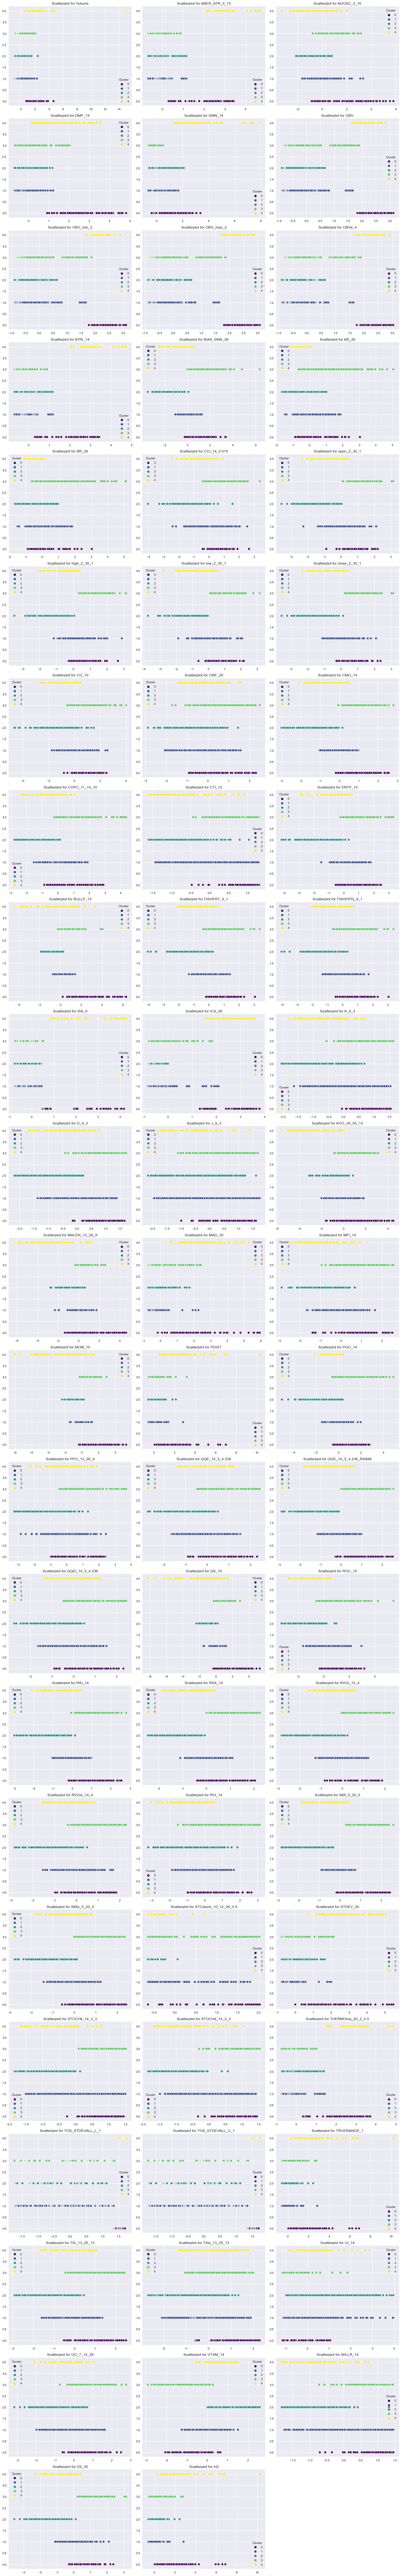

In [169]:
# Extract cluster labels 
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(Xtrain_kmeans)
clusters = kmeans.labels_

# Plot scatterplots for each feature 
num_features = Xtrain_kmeans.shape[1]
num_plots_per_row = 3
num_rows = num_features // num_plots_per_row + (num_features % num_plots_per_row > 0)

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(18, num_rows * 5))
axes = axes.flatten()

# Use the saved column names for plotting
for i, col in enumerate(column_names):
    sns.scatterplot(x=Xtrain_kmeans[:, i], y=clusters, hue=clusters, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Scatterplot for {col}')
    axes[i].legend(title='Cluster')

# Hide unused subplots
for j in range(i+1, num_rows*num_plots_per_row):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

The scatterplots illustrate the distribution of data points across clusters for various features in a multi-dimensional dataset. Each plot corresponds to a specific feature, with the horizontal axis representing the feature's value range and the vertical axis denoting the cluster assignments. The data points are color-coded according to their cluster label, facilitating a visual assessment of the cluster's cohesion and separation. If a feature has values that are spread out across different clusters without much overlap, it may be a good candidate for distinguishing between clusters. On the other hand, if the values for a particular feature are grouped together across different clusters, it might not be as useful for differentiation. In essence, variance quantifies the amount of information or variability present in a feature. 

### Mutual Information

In [94]:
# Convert the numpy arrays to DataFrames 
Xtrain_kmeans = pd.DataFrame(Xtrain_kmeans, columns=column_names)
Xval_boruta = pd.DataFrame(scaledval, columns=selected_features_df.columns)  # Adjust as per actual column names
Xtest_boruta = pd.DataFrame(scaledtest, columns=selected_features_df.columns) # Adjust as per actual column names

# Calculate Mutual Information for each feature
mi = mutual_info_classif(Xtrain_kmeans, ytrain)
mi_data = pd.DataFrame({'feature': Xtrain_kmeans.columns, 'mutual_info': mi})

# Sort features by their mutual information
mi_data = mi_data.sort_values(by='mutual_info', ascending=False)

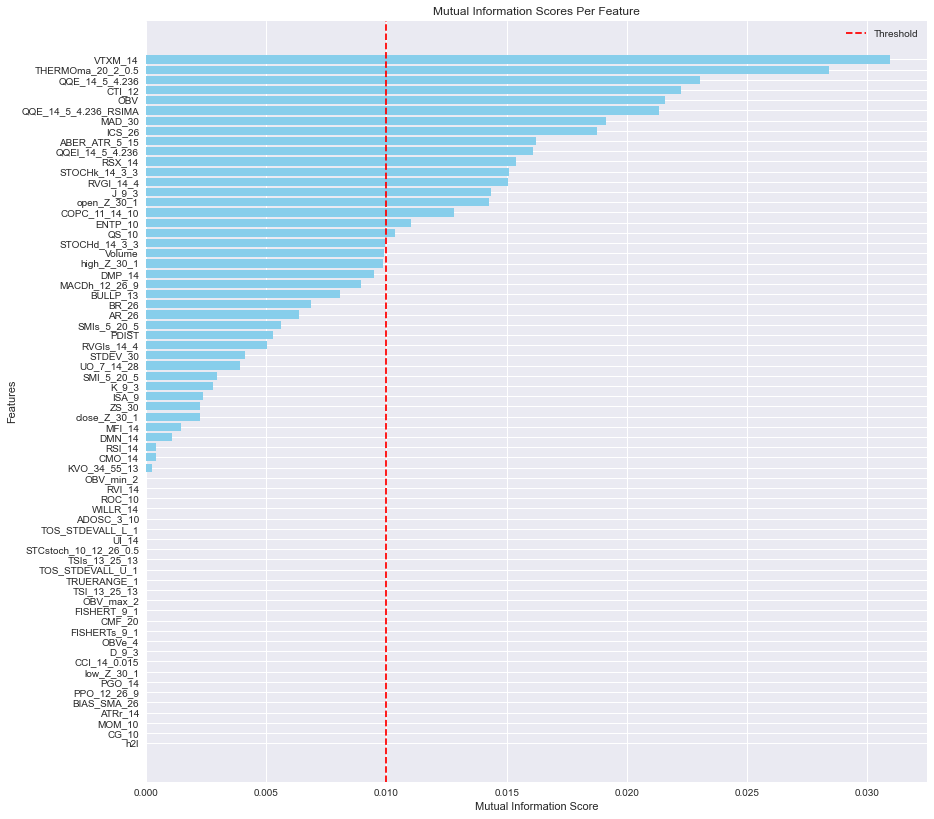

In [96]:
mi_data = mi_data.sort_values(by='mutual_info', ascending=True)

# Plot the graph
plt.figure(figsize=(14, 14))
plt.barh(mi_data['feature'], mi_data['mutual_info'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information Scores Per Feature')

# Draw a line for the threshold
plt.axvline(x=0.01, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.show()

In [99]:
# Define a threshold for mutual information
mi_threshold = 0.01  # Adjust this based on your specific dataset

# Identify features to drop based on mutual information threshold
features_to_drop_mi = mi_data[mi_data['mutual_info'] < mi_threshold]['feature'].tolist()

# Drop features from the training data based on mutual information
Xtrain_final = Xtrain_kmeans.drop(columns=features_to_drop_mi)

# Drop KMeans filtered columns from validation and test sets
Xval_kmeans = Xval_boruta.drop(columns=features_to_drop_names)
Xtest_kmeans = Xtest_boruta.drop(columns=features_to_drop_names)

# Drop Mutual Information filtered columns from validation and test sets
Xval_final = Xval_kmeans.drop(columns=features_to_drop_mi)
Xtest_final = Xtest_kmeans.drop(columns=features_to_drop_mi)

In [100]:
Xtest_final

,ABER_ATR_5_15,OBV,open_Z_30_1,COPC_11_14_10,CTI_12,ENTP_10,ICS_26,J_9_3,MAD_30,QQE_14_5_4.236,QQE_14_5_4.236_RSIMA,QQEl_14_5_4.236,QS_10,RSX_14,RVGI_14_4,STOCHk_14_3_3,THERMOma_20_2_0.5,VTXM_14
0,0.162366,1.367397,-0.988545,-0.159530,-0.947040,-0.122785,0.462900,-1.366447,-0.130913,-0.249562,-0.749048,-0.249562,-0.742799,-0.377256,-0.234060,-0.976353,0.445442,0.335672
1,0.158629,1.311714,-0.844361,-0.269733,-1.462666,-0.386403,0.477983,-1.462407,-0.155732,-0.377273,-0.875813,-0.377273,-1.101619,-0.535203,-0.253353,-1.268452,0.394281,0.402018
2,0.199095,1.241543,-1.277054,-0.404533,-1.509189,-0.646598,0.499251,-1.598727,-0.163385,-0.509990,-1.007373,-0.509990,-1.264324,-0.713226,-0.278180,-1.423896,0.363744,0.107521
3,0.211539,1.303801,-1.443133,-0.467950,-1.425347,-0.827402,0.482973,-0.662585,-0.199063,-0.509990,-0.907800,-0.509990,-1.160021,-0.785961,-0.264313,-1.439150,0.288010,0.182408
4,0.208815,1.244933,-0.741707,-0.591880,-1.310933,-0.829962,0.468310,-0.225609,-0.228608,-0.509990,-0.859734,-0.509990,-0.426225,-0.807193,-0.372511,-1.307816,0.217006,0.931661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1.189673,1.108775,2.076205,0.007360,1.048771,0.259320,-0.971765,0.835864,0.103561,0.074588,0.506737,0.074588,1.356703,0.399071,0.189680,0.766609,1.245352,-0.558333
478,1.292807,1.184622,1.367639,0.082425,1.064478,0.359928,-0.971690,0.898095,0.143781,0.157345,0.585687,0.157345,1.503892,0.522108,0.341032,1.005988,1.171314,-0.460518
479,1.398416,1.115254,1.455394,0.149275,1.036544,0.363424,-0.971765,0.609497,0.171006,0.177727,0.602234,0.177727,0.689763,0.603177,0.386419,0.680169,1.192624,-0.608415
480,1.593236,1.049671,1.170508,0.087466,0.411790,0.207498,-0.971765,-0.707470,0.172102,0.177727,0.228606,0.177727,-0.909772,0.418632,0.282184,0.096308,1.598227,-0.283428


### Sequence Data Generation

In many-to-one sequence problem, the input of the LSTM is always a 3D array and the time series data must be transformed into a structure of samples with input and output components before it can be used to fit a supervised learning model.

The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples, ready to train deep learning models.

In [101]:
# sequence length
seqlen = 15

# number of features
numfeat = Xtrain_final.shape[1]

In [102]:
# Create the generator for training data
g_train = TimeseriesGenerator(Xtrain_final, ytrain, length=seqlen, batch_size=32)  

# Create the generator for test data
g_test = TimeseriesGenerator(Xtest_final, ytest, length=seqlen, batch_size=32)

# Create the generator for validation data
g_val = TimeseriesGenerator(Xval_final, yval, length=seqlen, batch_size=32)  

In [103]:
# verify length
len(g_train), len(g_test), len(g_val)

(45, 15, 15)

In [104]:
# check feature set
g_train[0][0]

array([[[-0.55797146, -0.88602601,  1.12618597, ...,  1.24925586,
         -0.60260371, -1.24450543],
        [-0.53350864, -0.88991493,  1.04563901, ...,  0.97624851,
         -0.56988521, -1.02404259],
        [-0.53958616, -0.88721913,  0.47888727, ...,  0.65544099,
         -0.55819926, -0.67618189],
        ...,
        [-0.56782997, -0.88485519,  0.27629858, ...,  0.28328779,
         -0.60249255,  0.43150429],
        [-0.56826274, -0.88634256,  0.33714814, ...,  0.16413348,
         -0.60109556,  0.53344095],
        [-0.57213583, -0.88809985, -0.08184741, ..., -0.00782321,
         -0.60731327,  0.7520328 ]],

       [[-0.53350864, -0.88991493,  1.04563901, ...,  0.97624851,
         -0.56988521, -1.02404259],
        [-0.53958616, -0.88721913,  0.47888727, ...,  0.65544099,
         -0.55819926, -0.67618189],
        [-0.52564182, -0.88978683,  0.50385728, ..., -0.09650616,
         -0.54302388, -0.59294104],
        ...,
        [-0.56826274, -0.88634256,  0.33714814, ...,  

In [105]:
# check target 
g_train[0][1]

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1])

In [106]:
# verify batch size
for i in range(len(g_train)):
    a, b = g_train[i]
    print(a.shape, b.shape)

(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(32, 15, 18) (32,)
(21, 15, 18) (21,)


### Build Neural Network

The Sequential class from the Keras model API is used to stack the LSTM Recurrent Neural Network layers. The model is then compiled and trained with the defined configurations. Iteratively adjusting the epochs and batch size can enhance accuracy.

In [107]:
# Create a sequential model
def create_model(hu=256, lookback=60, features=1):
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM1'))
    model.add(Dropout(0.4, name='Drouput1'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=True, name='LSTM2'))
    model.add(Dropout(0.4, name='Drouput2'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))             
    
    # specify optimizer separately (preferred method)
    opt = Adam(learning_rate=0.001, epsilon=1e-08)       
    
    # model compilation 
    model.compile(optimizer=opt, 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

In [108]:
# lstm network
model = create_model(hu=10, lookback=seqlen, features=numfeat)

In [109]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 15, 20)            3120      
_________________________________________________________________
Drouput1 (Dropout)           (None, 15, 20)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 15, 10)            1240      
_________________________________________________________________
Drouput2 (Dropout)           (None, 15, 10)            0         
_________________________________________________________________
LSTM3 (LSTM)                 (None, 10)                840       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
______________________________________________________

In [110]:
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("./tensorboard/logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)]

In [111]:
# Model fitting
model.fit(
    g_train,  
    epochs=500,
    verbose=1,
    callbacks=my_callbacks,
    shuffle=False,
    class_weight=class_weight,
    validation_data=g_val  
)

Epoch 1/500
45/45 [==============================] - 7s 75ms/step - loss: 0.6951 - accuracy: 0.5031 - precision: 0.4904 - recall: 0.7033 - auc: 0.5232 - val_loss: 0.6976 - val_accuracy: 0.4904 - val_precision: 0.4733 - val_recall: 0.8571 - val_auc: 0.5235

Epoch 00001: loss improved from inf to 0.69512, saving model to results/lstm_time_series/model.h5
Epoch 2/500
45/45 [==============================] - 1s 29ms/step - loss: 0.6932 - accuracy: 0.5276 - precision: 0.5097 - recall: 0.6093 - auc: 0.5416 - val_loss: 0.7060 - val_accuracy: 0.4625 - val_precision: 0.4601 - val_recall: 0.9032 - val_auc: 0.4906

Epoch 00002: loss improved from 0.69512 to 0.69323, saving model to results/lstm_time_series/model.h5
Epoch 3/500
45/45 [==============================] - 1s 28ms/step - loss: 0.6904 - accuracy: 0.5430 - precision: 0.5214 - recall: 0.6686 - auc: 0.5561 - val_loss: 0.7143 - val_accuracy: 0.4754 - val_precision: 0.4679 - val_recall: 0.9401 - val_auc: 0.5219

Epoch 00003: loss improved fr

### Evaluate model performance

In [49]:
%tensorboard --logdir ./tensorboard/logs --port 6020

### Prediction

In [112]:
# predictions  
ytest_pred = np.where(model.predict(g_test, verbose=False) > 0.5, 1, 0) # Convert probabilities to class labels

ytest_pred[-10:]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

### Calculate Metrics

To evaluate the performance of the model, various metrics sre calculated. These include training and test accuracy, which provide a basic measure of the model's effectiveness in classifying the data correctly. A confusion matrix is also generated to visualize the model's performance in terms of false positives and negatives. Additionally, a classification report is created, offering a view of precision, recall, and F1-score. The model's ability to discriminate between classes was further assessed using the ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) score, which help understanding performance in binary classification tasks. These metrics collectively offer a comprehensive view of the model's effectiveness.

In [113]:
# For training accuracy
ytrain_pred = model.predict(g_train)
ytrain_pred = np.where(ytrain_pred > 0.5, 1, 0)  # Convert probabilities to class labels
ytrain_true = ytrain[seqlen:]  # Adjust y_train to match the length of y_train_pred
acc_train = accuracy_score(ytrain_true, ytrain_pred)

# For test accuracy
ytest_true = ytest[seqlen:]  # Adjust ytest to match the length of ypred
acc_test = accuracy_score(ytest_true, ytest_pred)

# Print accuracies
print(f'Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}')

Train Accuracy: 0.7103, Test Accuracy: 0.4882


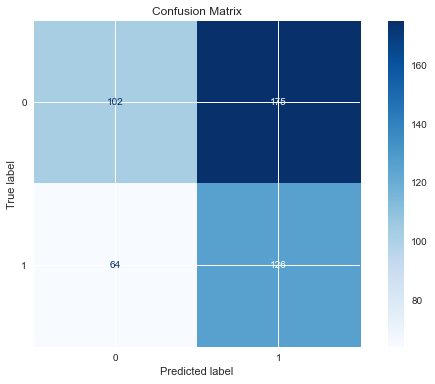

In [114]:
ytest_pred = ytest_pred.flatten() # convert to a 1D array

# Create confusion matrix
cm = confusion_matrix(ytest_true, ytest_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [115]:
# Generate classification report
report = classification_report(ytest_true, ytest_pred, target_names=['Class 0', 'Class 1'])

print(report)

              precision    recall  f1-score   support

     Class 0       0.61      0.37      0.46       277
     Class 1       0.42      0.66      0.51       190

    accuracy                           0.49       467
   macro avg       0.52      0.52      0.49       467
weighted avg       0.53      0.49      0.48       467



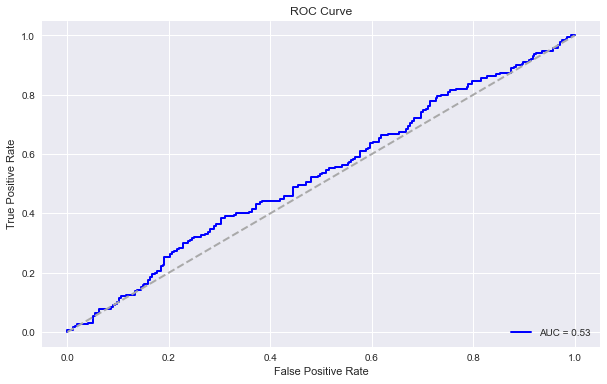

In [116]:
# Generate probability predictions
y_proba = model.predict(g_test).flatten()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(ytest_true, y_proba)

# Calculate AUC using roc_auc_score
roc_auc = roc_auc_score(ytest_true, y_proba)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

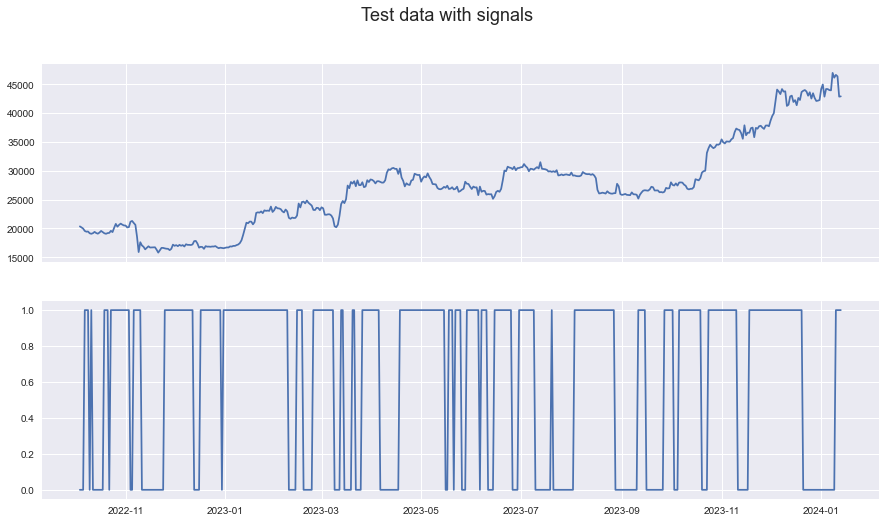

In [117]:
# plot predictions
df1 = df.Close[-(len(Xtest)-seqlen):]
fig, axs = plt.subplots(2, sharex=True, figsize=(15,8))
fig.suptitle('Test data with signals', size=18)
axs[0].plot(df1.index, df1)
axs[1].plot(df1.index, ytest_pred);

### Load Saved Model

The saved model is loaded. The function returns the model with the same architecture and weights and avoid tuning the model everytime.

In [118]:
# load model 
model = load_model(model_path)

# summarize model
model.summary()

# evaluate the model
score = model.evaluate(g_test, verbose=0)
print(f'{model.metrics_names[1]}, {score[1]*100:.4}%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 15, 20)            3120      
_________________________________________________________________
Drouput1 (Dropout)           (None, 15, 20)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 15, 10)            1240      
_________________________________________________________________
Drouput2 (Dropout)           (None, 15, 10)            0         
_________________________________________________________________
LSTM3 (LSTM)                 (None, 10)                840       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
______________________________________________________

### Hyperparameter Optimization

An approach using Optuna for hyperparameter optimization is adopted, with a focus on maximizing the weighted F1 score as the objectove function.

Optuna is a hyperparameter tuning framework that uses Bayesian optimization techniques. It is designed to automate the process using probabilistic models to predict the most promising parameter combinations. This approach can lead to quicker and more accurate identification of optimal settings compared to traditional grid or random search methods, particularly in complex models where the hyperparameter space is vast.

The weighted F1 score is a metric that combines the precision and recall of a classifier into a single measure, accounting for label imbalance. It does this by weighing the F1 score of each class by the number of true instances for each class, providing a better measure of the model's performance across a dataset that may not be uniformly distributed among classes. This makes it especially useful in scenarios where one class might dominate over others. 

In [119]:
callback = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
             TensorBoard(log_dir="./tensorboard/bologs")]

The 'create_model' function bellow dynamically constructs a LSTM-based Sequential model with varying numbers of layers, dropout rates, and learning rates, all of which are optimized using Optuna's trial suggestions. 

In [120]:
def create_model(trial):
    # Hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 5)  # Number of LSTM layers
    hp_dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    hp_learning_rate = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])

    model = Sequential()

    # Adding LSTM layers dynamically
    for i in range(num_layers):
        return_sequences = True if i < num_layers - 1 else False  # For the last layer, return_sequences is False
        units = trial.suggest_int(f'units_l{i}', 4, 32, step=4)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'elu', 'leaky_relu'])
        if i == 0:
            model.add(LSTM(units, input_shape=(seqlen, numfeat), activation=activation, return_sequences=return_sequences, name=f'LSTM_{i+1}'))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=return_sequences, name=f'LSTM_{i+1}'))
        model.add(Dropout(hp_dropout_rate, name=f'Dropout_{i+1}'))

    model.add(Dense(units=1, activation='sigmoid', name='Output'))

    # Optimizer
    opt = Adam(learning_rate=hp_learning_rate, epsilon=1e-08, decay=0.0)

    # Model compilation
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    return model

In [145]:
def calculate_weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

def objective(trial):
    model = create_model(trial)
    model.fit(
        g_train,
        epochs=50,
        verbose=1,
        callbacks=callback,
        shuffle=False,
        class_weight=class_weight,
        validation_data=g_val
    )
    
    y_pred = np.where(model.predict(g_val, verbose=False) > 0.5, 1, 0).flatten()

    # Get the labels from validation data
    y_true = yval[seqlen:]  

    weighted_f1 = calculate_weighted_f1(y_true, y_pred)
    
    return weighted_f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# After the study
best_trial = study.best_trial
print('Best trial:', best_trial.params)

[I 2024-01-13 19:04:56,167] A new study created in memory with name: no-name-bbb77f42-9081-402c-a0cf-a2c940add82b


Epoch 1/50
45/45 [==============================] - 5s 50ms/step - loss: 0.7194 - accuracy: 0.4773 - precision: 0.4749 - recall: 0.7670 - auc: 0.4797 - val_loss: 0.7097 - val_accuracy: 0.5289 - val_precision: 0.4908 - val_recall: 0.3687 - val_auc: 0.5122
Epoch 2/50
45/45 [==============================] - 1s 26ms/step - loss: 0.7175 - accuracy: 0.4647 - precision: 0.4655 - recall: 0.7236 - auc: 0.4621 - val_loss: 0.7047 - val_accuracy: 0.5268 - val_precision: 0.4885 - val_recall: 0.3917 - val_auc: 0.5138
Epoch 3/50
45/45 [==============================] - 1s 22ms/step - loss: 0.7061 - accuracy: 0.4948 - precision: 0.4851 - recall: 0.7294 - auc: 0.5002 - val_loss: 0.7009 - val_accuracy: 0.5225 - val_precision: 0.4837 - val_recall: 0.4101 - val_auc: 0.5219
Epoch 4/50
45/45 [==============================] - 1s 25ms/step - loss: 0.7057 - accuracy: 0.4913 - precision: 0.4824 - recall: 0.7120 - auc: 0.5005 - val_loss: 0.6987 - val_accuracy: 0.5225 - val_precision: 0.4844 - val_recall: 0.428

[I 2024-01-13 19:05:19,111] Trial 0 finished with value: 0.5072482290930671 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'units_l0': 24, 'activation_l0': 'relu', 'units_l1': 8, 'activation_l1': 'elu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 10s 92ms/step - loss: 0.7008 - accuracy: 0.4969 - precision: 0.4854 - recall: 0.6744 - auc: 0.4966 - val_loss: 0.7012 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5065
Epoch 2/50
45/45 [==============================] - 2s 35ms/step - loss: 0.6970 - accuracy: 0.4976 - precision: 0.4851 - recall: 0.6382 - auc: 0.5122 - val_loss: 0.7000 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5073
Epoch 3/50
45/45 [==============================] - 2s 47ms/step - loss: 0.7017 - accuracy: 0.4773 - precision: 0.4684 - recall: 0.6006 - auc: 0.4707 - val_loss: 0.6986 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5102
Epoch 4/50
45/45 [==============================] - 2s 37ms/step - loss: 0.6978 - accuracy: 0.4843 - precision: 0.4733 - recall: 0.5904 - auc: 0.4880 - val_loss: 0.6977 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.00

[I 2024-01-13 19:06:23,984] Trial 1 finished with value: 0.2948332644602227 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'units_l0': 4, 'activation_l0': 'relu', 'units_l1': 24, 'activation_l1': 'leaky_relu', 'units_l2': 20, 'activation_l2': 'leaky_relu', 'units_l3': 4, 'activation_l3': 'elu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 9s 88ms/step - loss: 0.6947 - accuracy: 0.5003 - precision: 0.4901 - recall: 0.8278 - auc: 0.4983 - val_loss: 0.6946 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.4942
Epoch 2/50
45/45 [==============================] - 2s 39ms/step - loss: 0.6947 - accuracy: 0.4934 - precision: 0.4867 - recall: 0.8726 - auc: 0.4984 - val_loss: 0.6951 - val_accuracy: 0.4668 - val_precision: 0.4649 - val_recall: 0.9770 - val_auc: 0.4863
Epoch 3/50
45/45 [==============================] - 2s 39ms/step - loss: 0.6948 - accuracy: 0.5052 - precision: 0.4932 - recall: 0.8408 - auc: 0.4962 - val_loss: 0.6960 - val_accuracy: 0.4604 - val_precision: 0.4619 - val_recall: 0.9770 - val_auc: 0.4963
Epoch 4/50
45/45 [==============================] - 2s 41ms/step - loss: 0.6935 - accuracy: 0.5052 - precision: 0.4936 - recall: 0.8944 - auc: 0.5297 - val_loss: 0.6974 - val_accuracy: 0.4604 - val_precision: 0.4619 - val_recall: 0.977

[I 2024-01-13 19:07:46,744] Trial 2 finished with value: 0.3012956612036191 and parameters: {'num_layers': 4, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'units_l0': 4, 'activation_l0': 'relu', 'units_l1': 4, 'activation_l1': 'relu', 'units_l2': 24, 'activation_l2': 'relu', 'units_l3': 32, 'activation_l3': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 6s 57ms/step - loss: 0.7545 - accuracy: 0.5129 - precision: 0.4444 - recall: 0.0289 - auc: 0.4786 - val_loss: 0.7031 - val_accuracy: 0.5246 - val_precision: 0.2222 - val_recall: 0.0092 - val_auc: 0.4722
Epoch 2/50
45/45 [==============================] - 1s 28ms/step - loss: 0.7380 - accuracy: 0.5171 - precision: 0.5098 - recall: 0.0376 - auc: 0.4760 - val_loss: 0.7019 - val_accuracy: 0.5225 - val_precision: 0.2000 - val_recall: 0.0092 - val_auc: 0.4785
Epoch 3/50
45/45 [==============================] - 1s 25ms/step - loss: 0.7304 - accuracy: 0.5122 - precision: 0.4559 - recall: 0.0449 - auc: 0.4878 - val_loss: 0.7006 - val_accuracy: 0.5225 - val_precision: 0.2000 - val_recall: 0.0092 - val_auc: 0.4788
Epoch 4/50
45/45 [==============================] - 1s 23ms/step - loss: 0.7299 - accuracy: 0.5003 - precision: 0.3614 - recall: 0.0434 - auc: 0.4718 - val_loss: 0.6994 - val_accuracy: 0.5246 - val_precision: 0.2222 - val_recall: 0.009

[I 2024-01-13 19:08:27,263] Trial 3 finished with value: 0.4181007912197753 and parameters: {'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'units_l0': 4, 'activation_l0': 'relu', 'units_l1': 24, 'activation_l1': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 12s 92ms/step - loss: 0.6982 - accuracy: 0.4759 - precision: 0.4753 - recall: 0.8075 - auc: 0.4633 - val_loss: 0.6950 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5147
Epoch 2/50
45/45 [==============================] - 2s 39ms/step - loss: 0.6969 - accuracy: 0.4829 - precision: 0.4811 - recall: 0.8857 - auc: 0.4975 - val_loss: 0.6950 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.4883
Epoch 3/50
45/45 [==============================] - 2s 45ms/step - loss: 0.6981 - accuracy: 0.4948 - precision: 0.4880 - recall: 0.9146 - auc: 0.4974 - val_loss: 0.6956 - val_accuracy: 0.4604 - val_precision: 0.4458 - val_recall: 0.6636 - val_auc: 0.4821
Epoch 4/50
45/45 [==============================] - 2s 42ms/step - loss: 0.7116 - accuracy: 0.4969 - precision: 0.4892 - recall: 0.9190 - auc: 0.5105 - val_loss: 0.6970 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.00

[I 2024-01-13 19:09:21,959] Trial 4 finished with value: 0.49138629312584586 and parameters: {'num_layers': 5, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'units_l0': 24, 'activation_l0': 'leaky_relu', 'units_l1': 8, 'activation_l1': 'leaky_relu', 'units_l2': 12, 'activation_l2': 'elu', 'units_l3': 4, 'activation_l3': 'elu', 'units_l4': 16, 'activation_l4': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 9s 89ms/step - loss: 0.6964 - accuracy: 0.4808 - precision: 0.4819 - recall: 0.9812 - auc: 0.4617 - val_loss: 0.6940 - val_accuracy: 0.4839 - val_precision: 0.4709 - val_recall: 0.8940 - val_auc: 0.4823
Epoch 2/50
45/45 [==============================] - 2s 39ms/step - loss: 0.6952 - accuracy: 0.4815 - precision: 0.4823 - recall: 0.9855 - auc: 0.4566 - val_loss: 0.6950 - val_accuracy: 0.4775 - val_precision: 0.4685 - val_recall: 0.9263 - val_auc: 0.4871
Epoch 3/50
45/45 [==============================] - 2s 37ms/step - loss: 0.6946 - accuracy: 0.4808 - precision: 0.4811 - recall: 0.9392 - auc: 0.4905 - val_loss: 0.6958 - val_accuracy: 0.4818 - val_precision: 0.4684 - val_recall: 0.8525 - val_auc: 0.4817
Epoch 4/50
45/45 [==============================] - 2s 36ms/step - loss: 0.6941 - accuracy: 0.4927 - precision: 0.4863 - recall: 0.8712 - auc: 0.5052 - val_loss: 0.6967 - val_accuracy: 0.4732 - val_precision: 0.4645 - val_recall: 0.875

[I 2024-01-13 19:10:53,761] Trial 5 finished with value: 0.4755675360719919 and parameters: {'num_layers': 4, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'units_l0': 4, 'activation_l0': 'relu', 'units_l1': 32, 'activation_l1': 'elu', 'units_l2': 16, 'activation_l2': 'elu', 'units_l3': 16, 'activation_l3': 'leaky_relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 5s 49ms/step - loss: 0.7285 - accuracy: 0.4815 - precision: 0.4585 - recall: 0.3994 - auc: 0.4799 - val_loss: 0.7251 - val_accuracy: 0.5353 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4861
Epoch 2/50
45/45 [==============================] - 1s 25ms/step - loss: 0.7180 - accuracy: 0.4829 - precision: 0.4646 - recall: 0.4559 - auc: 0.4774 - val_loss: 0.7085 - val_accuracy: 0.5332 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4760
Epoch 3/50
45/45 [==============================] - 1s 21ms/step - loss: 0.7113 - accuracy: 0.4654 - precision: 0.4543 - recall: 0.5253 - auc: 0.4690 - val_loss: 0.7012 - val_accuracy: 0.5182 - val_precision: 0.2500 - val_recall: 0.0184 - val_auc: 0.4716
Epoch 4/50
45/45 [==============================] - 1s 19ms/step - loss: 0.6996 - accuracy: 0.4990 - precision: 0.4848 - recall: 0.5789 - auc: 0.5107 - val_loss: 0.6992 - val_accuracy: 0.5054 - val_precision: 0.4000 - v

[I 2024-01-13 19:11:15,481] Trial 6 finished with value: 0.48060053412891274 and parameters: {'num_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'units_l0': 20, 'activation_l0': 'elu', 'units_l1': 32, 'activation_l1': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 12s 97ms/step - loss: 0.6960 - accuracy: 0.4668 - precision: 0.4526 - recall: 0.4906 - auc: 0.4780 - val_loss: 0.6932 - val_accuracy: 0.4925 - val_precision: 0.4691 - val_recall: 0.7005 - val_auc: 0.5082
Epoch 2/50
45/45 [==============================] - 2s 42ms/step - loss: 0.6939 - accuracy: 0.5010 - precision: 0.4895 - recall: 0.7395 - auc: 0.5258 - val_loss: 0.6934 - val_accuracy: 0.4668 - val_precision: 0.4651 - val_recall: 0.9816 - val_auc: 0.4857
Epoch 3/50
45/45 [==============================] - 2s 45ms/step - loss: 0.6946 - accuracy: 0.4969 - precision: 0.4882 - recall: 0.8365 - auc: 0.5203 - val_loss: 0.6936 - val_accuracy: 0.4647 - val_precision: 0.4641 - val_recall: 0.9816 - val_auc: 0.4949
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.6947 - accuracy: 0.4731 - precision: 0.4753 - recall: 0.8640 - auc: 0.4983 - val_loss: 0.6939 - val_accuracy: 0.4604 - val_precision: 0.4620 - val_recall: 0.98

[I 2024-01-13 19:11:41,178] Trial 7 finished with value: 0.3139263827914791 and parameters: {'num_layers': 5, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'units_l0': 4, 'activation_l0': 'relu', 'units_l1': 28, 'activation_l1': 'leaky_relu', 'units_l2': 32, 'activation_l2': 'leaky_relu', 'units_l3': 8, 'activation_l3': 'elu', 'units_l4': 32, 'activation_l4': 'elu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 7s 67ms/step - loss: 0.6953 - accuracy: 0.4948 - precision: 0.4861 - recall: 0.7858 - auc: 0.5296 - val_loss: 0.7145 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.4922
Epoch 2/50
45/45 [==============================] - 1s 33ms/step - loss: 0.6934 - accuracy: 0.5045 - precision: 0.4921 - recall: 0.7699 - auc: 0.5447 - val_loss: 0.7078 - val_accuracy: 0.4668 - val_precision: 0.4657 - val_recall: 1.0000 - val_auc: 0.4901
Epoch 3/50
45/45 [==============================] - 1s 32ms/step - loss: 0.6924 - accuracy: 0.5115 - precision: 0.4966 - recall: 0.7410 - auc: 0.5479 - val_loss: 0.7052 - val_accuracy: 0.4647 - val_precision: 0.4645 - val_recall: 0.9954 - val_auc: 0.4909
Epoch 4/50
45/45 [==============================] - 1s 28ms/step - loss: 0.6916 - accuracy: 0.5234 - precision: 0.5050 - recall: 0.7265 - auc: 0.5495 - val_loss: 0.7036 - val_accuracy: 0.4647 - val_precision: 0.4645 - val_recall: 0.995

[I 2024-01-13 19:12:51,455] Trial 8 finished with value: 0.46715171249693055 and parameters: {'num_layers': 3, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'units_l0': 28, 'activation_l0': 'elu', 'units_l1': 32, 'activation_l1': 'relu', 'units_l2': 12, 'activation_l2': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 7s 68ms/step - loss: 0.7342 - accuracy: 0.5108 - precision: 0.4950 - recall: 0.5760 - auc: 0.5119 - val_loss: 0.6934 - val_accuracy: 0.5225 - val_precision: 0.4643 - val_recall: 0.1797 - val_auc: 0.4946
Epoch 2/50
45/45 [==============================] - 1s 31ms/step - loss: 0.7317 - accuracy: 0.4864 - precision: 0.4755 - recall: 0.6035 - auc: 0.4933 - val_loss: 0.6966 - val_accuracy: 0.4754 - val_precision: 0.4662 - val_recall: 0.8894 - val_auc: 0.5275
Epoch 3/50
45/45 [==============================] - 1s 30ms/step - loss: 0.7418 - accuracy: 0.4871 - precision: 0.4840 - recall: 0.9204 - auc: 0.4843 - val_loss: 0.6962 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/50
45/45 [==============================] - 1s 28ms/step - loss: 0.7001 - accuracy: 0.4801 - precision: 0.4814 - recall: 0.9725 - auc: 0.4830 - val_loss: 0.6957 - val_accuracy: 0.4690 - val_precision: 0.4667 - val_recall: 1.000

[I 2024-01-13 19:13:27,268] Trial 9 finished with value: 0.2948332644602227 and parameters: {'num_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'units_l0': 28, 'activation_l0': 'elu', 'units_l1': 24, 'activation_l1': 'elu', 'units_l2': 8, 'activation_l2': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 61s 48ms/step - loss: 0.8235 - accuracy: 0.5339 - precision: 0.5147 - recall: 0.6324 - auc: 0.5388 - val_loss: 0.9505 - val_accuracy: 0.4647 - val_precision: 0.4641 - val_recall: 0.9816 - val_auc: 0.5084
Epoch 2/50
45/45 [==============================] - 1s 15ms/step - loss: 0.7211 - accuracy: 0.5234 - precision: 0.5063 - recall: 0.5861 - auc: 0.5273 - val_loss: 0.7426 - val_accuracy: 0.4475 - val_precision: 0.4384 - val_recall: 0.6728 - val_auc: 0.4807
Epoch 3/50
45/45 [==============================] - 1s 15ms/step - loss: 0.6959 - accuracy: 0.5346 - precision: 0.5163 - recall: 0.5948 - auc: 0.5459 - val_loss: 0.7135 - val_accuracy: 0.4604 - val_precision: 0.4335 - val_recall: 0.5253 - val_auc: 0.4777
Epoch 4/50
45/45 [==============================] - 1s 16ms/step - loss: 0.6991 - accuracy: 0.5185 - precision: 0.5018 - recall: 0.6006 - auc: 0.5374 - val_loss: 0.7123 - val_accuracy: 0.4946 - val_precision: 0.4566 - val_recall: 0.46

[I 2024-01-13 19:14:59,179] Trial 10 finished with value: 0.48749669537143314 and parameters: {'num_layers': 1, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units_l0': 12, 'activation_l0': 'leaky_relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 14s 145ms/step - loss: 0.7101 - accuracy: 0.4829 - precision: 0.4786 - recall: 0.7757 - auc: 0.4961 - val_loss: 0.6936 - val_accuracy: 0.5203 - val_precision: 0.4426 - val_recall: 0.1244 - val_auc: 0.4892
Epoch 2/50
45/45 [==============================] - 2s 44ms/step - loss: 0.6957 - accuracy: 0.4703 - precision: 0.4723 - recall: 0.8148 - auc: 0.4667 - val_loss: 0.6948 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.4980
Epoch 3/50
45/45 [==============================] - 2s 44ms/step - loss: 0.6953 - accuracy: 0.4836 - precision: 0.4836 - recall: 1.0000 - auc: 0.4625 - val_loss: 0.6952 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/50
45/45 [==============================] - 2s 43ms/step - loss: 0.6950 - accuracy: 0.4836 - precision: 0.4836 - recall: 1.0000 - auc: 0.4616 - val_loss: 0.6957 - val_accuracy: 0.4647 - val_precision: 0.4647 - val_recall: 1.0

[I 2024-01-13 19:15:35,324] Trial 11 finished with value: 0.2948332644602227 and parameters: {'num_layers': 5, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units_l0': 20, 'activation_l0': 'leaky_relu', 'units_l1': 8, 'activation_l1': 'elu', 'units_l2': 4, 'activation_l2': 'elu', 'units_l3': 20, 'activation_l3': 'elu', 'units_l4': 8, 'activation_l4': 'relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 4s 50ms/step - loss: 0.7320 - accuracy: 0.4962 - precision: 0.4827 - recall: 0.5861 - auc: 0.5000 - val_loss: 0.7154 - val_accuracy: 0.4925 - val_precision: 0.3649 - val_recall: 0.1244 - val_auc: 0.4603
Epoch 2/50
45/45 [==============================] - 1s 14ms/step - loss: 0.7091 - accuracy: 0.4976 - precision: 0.4860 - recall: 0.6758 - auc: 0.5032 - val_loss: 0.7023 - val_accuracy: 0.4625 - val_precision: 0.4444 - val_recall: 0.6267 - val_auc: 0.4883
Epoch 3/50
45/45 [==============================] - 1s 16ms/step - loss: 0.6934 - accuracy: 0.5500 - precision: 0.5309 - recall: 0.5962 - auc: 0.5493 - val_loss: 0.7044 - val_accuracy: 0.4754 - val_precision: 0.4247 - val_recall: 0.3641 - val_auc: 0.4602
Epoch 4/50
45/45 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5402 - precision: 0.5201 - recall: 0.6353 - auc: 0.5564 - val_loss: 0.7049 - val_accuracy: 0.4604 - val_precision: 0.4538 - val_recall: 0.792

[I 2024-01-13 19:16:10,540] Trial 12 finished with value: 0.49234245983593117 and parameters: {'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.01, 'units_l0': 32, 'activation_l0': 'leaky_relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 3s 35ms/step - loss: 0.7124 - accuracy: 0.4976 - precision: 0.4836 - recall: 0.5745 - auc: 0.5156 - val_loss: 0.6989 - val_accuracy: 0.5054 - val_precision: 0.4754 - val_recall: 0.6221 - val_auc: 0.4905
Epoch 2/50
45/45 [==============================] - 1s 14ms/step - loss: 0.7043 - accuracy: 0.4983 - precision: 0.4852 - recall: 0.6151 - auc: 0.5158 - val_loss: 0.6982 - val_accuracy: 0.4668 - val_precision: 0.4512 - val_recall: 0.6820 - val_auc: 0.4514
Epoch 3/50
45/45 [==============================] - 1s 14ms/step - loss: 0.6908 - accuracy: 0.5395 - precision: 0.5182 - recall: 0.6787 - auc: 0.5535 - val_loss: 0.7003 - val_accuracy: 0.4582 - val_precision: 0.4274 - val_recall: 0.4885 - val_auc: 0.4695
Epoch 4/50
45/45 [==============================] - 1s 14ms/step - loss: 0.7038 - accuracy: 0.5409 - precision: 0.5213 - recall: 0.6194 - auc: 0.5632 - val_loss: 0.6981 - val_accuracy: 0.4925 - val_precision: 0.4367 - val_recall: 0.318

[I 2024-01-13 19:16:25,560] Trial 13 finished with value: 0.36135486296505065 and parameters: {'num_layers': 1, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.01, 'units_l0': 32, 'activation_l0': 'leaky_relu'}. Best is trial 0 with value: 0.5072482290930671.


Epoch 1/50
45/45 [==============================] - 6s 55ms/step - loss: 0.7394 - accuracy: 0.5017 - precision: 0.4865 - recall: 0.5470 - auc: 0.4992 - val_loss: 0.7005 - val_accuracy: 0.4839 - val_precision: 0.4716 - val_recall: 0.9171 - val_auc: 0.4821
Epoch 2/50
45/45 [==============================] - 1s 24ms/step - loss: 0.6955 - accuracy: 0.5199 - precision: 0.5026 - recall: 0.7062 - auc: 0.5278 - val_loss: 0.7023 - val_accuracy: 0.4668 - val_precision: 0.4604 - val_recall: 0.8571 - val_auc: 0.4996
Epoch 3/50
45/45 [==============================] - 1s 23ms/step - loss: 0.6909 - accuracy: 0.5311 - precision: 0.5115 - recall: 0.6744 - auc: 0.5537 - val_loss: 0.7022 - val_accuracy: 0.4540 - val_precision: 0.4523 - val_recall: 0.8295 - val_auc: 0.4872
Epoch 4/50
45/45 [==============================] - 1s 24ms/step - loss: 0.6904 - accuracy: 0.5395 - precision: 0.5187 - recall: 0.6614 - auc: 0.5541 - val_loss: 0.7006 - val_accuracy: 0.4925 - val_precision: 0.4593 - val_recall: 0.520

[I 2024-01-13 19:17:04,785] Trial 14 finished with value: 0.3194370142550015 and parameters: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units_l0': 32, 'activation_l0': 'leaky_relu', 'units_l1': 16, 'activation_l1': 'elu'}. Best is trial 0 with value: 0.5072482290930671.


Best trial: {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'units_l0': 24, 'activation_l0': 'relu', 'units_l1': 8, 'activation_l1': 'elu'}


### Visualize the hyperparameter tuning process

TensorBoard is a useful tool for visualizing the machine learning experiments. It can monitor the losses and metrics during the model training and visualize the model architectures.

In [122]:
%tensorboard --logdir ./tensorboard/bologs --port 6025

### Retrieve the best hyperparameters

In [146]:
# After the study
best_params = study.best_trial.params
print("Best trial parameters: ", best_params)

Best trial parameters:  {'num_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'units_l0': 24, 'activation_l0': 'relu', 'units_l1': 8, 'activation_l1': 'elu'}


### Build Neural Network

In [147]:
def create_best_model(best_params):
    model = Sequential()

    num_layers = best_params['num_layers']  # Number of LSTM layers from the best parameters

    # Adding LSTM layers dynamically
    for i in range(num_layers):
        return_sequences = True if i < num_layers - 1 else False  # For the last layer, return_sequences is False
        units = best_params[f'units_l{i}']
        activation = best_params[f'activation_l{i}']

        if i == 0:
            model.add(LSTM(units, input_shape=(seqlen, numfeat), activation=activation, return_sequences=return_sequences, name=f'LSTM_{i+1}'))
        else:
            model.add(LSTM(units, activation=activation, return_sequences=return_sequences, name=f'LSTM_{i+1}'))
        model.add(Dropout(best_params['dropout_rate'], name=f'Dropout_{i+1}'))

    model.add(Dense(units=1, activation='sigmoid', name='Output'))

    # Optimizer
    learning_rate = best_params['learning_rate']
    opt = Adam(learning_rate=learning_rate, epsilon=1e-08, decay=0.0)

    # Model compilation
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    return model

best_model = create_best_model(best_params)

### Fit the tuned model

In [148]:
# 3. Fit the Model 
best_model.fit(
    g_train,  
    epochs=500,
    verbose=1,
    callbacks=my_callbacks,  
    shuffle=False,
    class_weight=class_weight,
    validation_data=g_val)  

Epoch 1/500
45/45 [==============================] - 6s 74ms/step - loss: 0.6991 - accuracy: 0.5157 - precision: 0.4995 - recall: 0.7844 - auc: 0.5592 - val_loss: 0.7331 - val_accuracy: 0.4690 - val_precision: 0.4650 - val_recall: 0.9493 - val_auc: 0.5351

Epoch 00001: loss did not improve from 0.53509
Epoch 2/500
45/45 [==============================] - 1s 21ms/step - loss: 0.7083 - accuracy: 0.5003 - precision: 0.4895 - recall: 0.7786 - auc: 0.5184 - val_loss: 0.7278 - val_accuracy: 0.4711 - val_precision: 0.4659 - val_recall: 0.9447 - val_auc: 0.5326

Epoch 00002: loss did not improve from 0.53509
Epoch 3/500
45/45 [==============================] - 1s 23ms/step - loss: 0.7016 - accuracy: 0.5276 - precision: 0.5076 - recall: 0.7728 - auc: 0.5460 - val_loss: 0.7232 - val_accuracy: 0.4668 - val_precision: 0.4633 - val_recall: 0.9309 - val_auc: 0.5293

Epoch 00003: loss did not improve from 0.53509
Epoch 4/500
45/45 [==============================] - 1s 26ms/step - loss: 0.6998 - accur

### Prediction

In [149]:
# Predictions on the test set
ytest_pred_prob = best_model.predict(g_test)
ytest_pred = np.where(ytest_pred_prob > 0.5, 1, 0)
ytest_pred[-10:]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### Metrics

In [150]:
# Predictions on the training set
ytrain_pred_prob = best_model.predict(g_train)
ytrain_pred = np.where(ytrain_pred_prob > 0.5, 1, 0)

# Calculate accuracies
acc_train = accuracy_score(ytrain_true, ytrain_pred)
acc_test = accuracy_score(ytest_true, ytest_pred)

print(f'Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}')

Train Accuracy: 0.6109, Test Accuracy: 0.4454


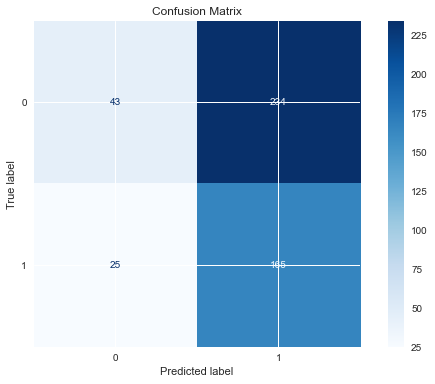

In [151]:
# Confusion Matrix for test data
cm = confusion_matrix(ytest_true, ytest_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [152]:
# Generate classification report
report = classification_report(ytest_true, ytest_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       0.63      0.16      0.25       277
     Class 1       0.41      0.87      0.56       190

    accuracy                           0.45       467
   macro avg       0.52      0.51      0.40       467
weighted avg       0.54      0.45      0.38       467



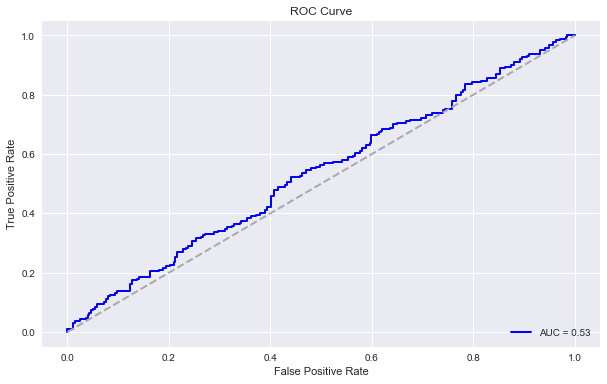

In [153]:
# Compute ROC curve and AUC for test data
fpr, tpr, thresholds = roc_curve(ytest_true, ytest_pred_prob)
roc_auc = roc_auc_score(ytest_true, ytest_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Trading Strategy

The trading strategy is based on applying the model's predictions to generate trading signals (1 and 0, representing 'buy' and 'do nothing', respectively). These signals are then used to create a strategy by multiplying the returns by the signals, adjusted for sequence length. Key metrics are also computed to evaluate the effectivenes of the strategy.

In [154]:
# Align the predictions with the test data in df
df_test = df.iloc[-len(Xtest_final):]  # Adjust based on the length of test set
df_test = df_test.iloc[seqlen:]  # Further adjust for the sequence length
df_test['Signal'] = ytest_pred.flatten()

In [155]:
df_test['Signal'].dropna(inplace=True)
df_test['Strategy'] = df_test['Return'] * df_test['Signal'].shift(1) 
df_test.dropna(subset=['Strategy', 'Return'], inplace=True)

### Plot the graph of strategy vs benchmark

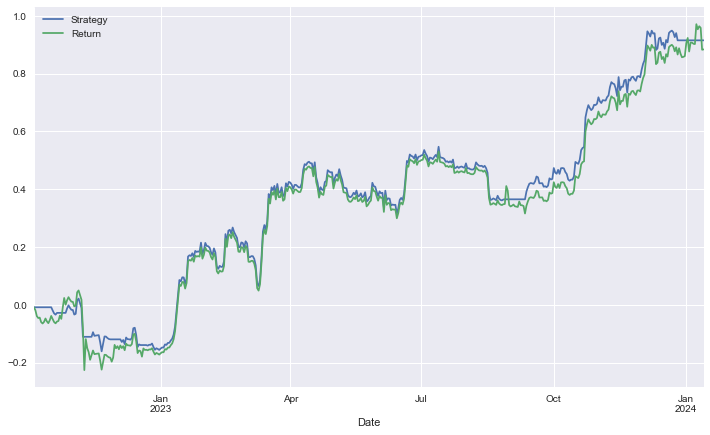

In [156]:
plt.figure(figsize=(12, 7))
df_test['Strategy'].cumsum().plot(label='Strategy')
df_test['Return'].cumsum().plot(label='Return')
plt.legend()
plt.show()

### Calculate metrics

In [157]:
# Function to calculate Maximum Drawdown
def max_drawdown(return_series):
    cum_returns = (1 + return_series).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = ((cum_returns / peak) - 1) * 100
    return drawdown.min()

# Calculate Total Return
total_return_strategy = ((df_test['Strategy'] + 1).prod() - 1) * 100 
total_return_return = ((df_test['Return'] + 1).prod() - 1) * 100

# Calculate Annualized Sharpe Ratio (Assuming risk-free rate = 0 and daily data)
annualized_sharpe_ratio_strategy = (df_test['Strategy'].mean() / df_test['Strategy'].std()) * np.sqrt(365)
annualized_sharpe_ratio_return = (df_test['Return'].mean() / df_test['Return'].std()) * np.sqrt(365)

# Calculate Maximum Drawdown
max_drawdown_strategy = max_drawdown(df_test['Strategy'])
max_drawdown_return = max_drawdown(df_test['Return'])

# Create a DataFrame for the results
metrics = pd.DataFrame({
    'Metric': ['Cumulative Return %', 'Sharpe Ratio', 'Max Drawdown %'],
    'Strategy': [total_return_strategy, annualized_sharpe_ratio_strategy, max_drawdown_strategy],
    'Benchmark': [total_return_return, annualized_sharpe_ratio_return, max_drawdown_return]
})

# Print the DataFrame
metrics.round(4)

,Metric,Strategy,Benchmark
0,Cumulative Return %,125.4583,110.9549
1,Sharpe Ratio,1.7860,1.4924
2,Max Drawdown %,-18.6954,-25.8210


## CONCLUSION

The model demonstrates advanced machine learning applications in Bitcoin prediction and trading strategies, using LSTM models for their ability to capture long-term dependencies and Optuna for efficient hyperparameter optimization. The model counters overfitting with a robust approach involving training, test, and validation datasets, ensuring broader applicability. 

However, it faces challenges like Bitcoin's market volatility and LSTM's complexity, which can introduce a bias-variance tradeoff. Practical limitations such as trade execution costs, latency, and the need for real-time data processing also impact the model's practical effectiveness, underscoring the importance of ongoing adaptation and refinement in this rapidly evolving domain.